In [2]:
import numpy as np
from matplotlib import pyplot as plt
import timeit

%matplotlib inline
%load_ext Cython

%load_ext autoreload
%autoreload 2

In [2]:
import montecarlo as mc

from quantum_montecarlo import quantum_cython_mcmc

array([1, 2, 3])

In [5]:
config = dict(N_steps = 10**5,
                N_system = 101,
                mu = 0,
                beta = 0.7,
                V=-1,
                alpha=1.5,
               )

#mc.py_srand48(52)
%time names, (lenergies, lnumbers, lmagnetisations) = cython_mcmc(**config)

CPU times: user 3.57 s, sys: 4.41 ms, total: 3.57 s
Wall time: 3.57 s


100000


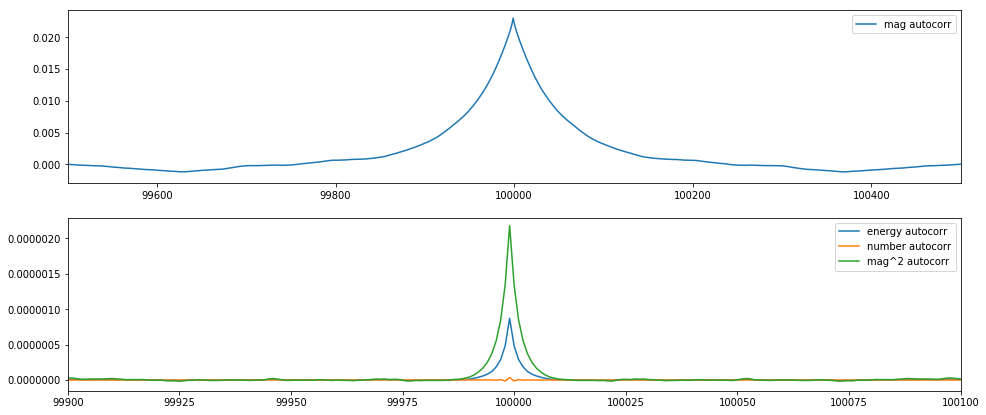

In [6]:


f, axs = plt.subplots(2, figsize = (16,7))
axs[1].plot(autocorrelation(lenergies), label = 'energy autocorr')
axs[0].plot(autocorrelation(lmagnetisations), label = 'mag autocorr')
axs[1].plot(autocorrelation(lnumbers), label = 'number autocorr')
axs[1].plot(autocorrelation(lmagnetisations**2), label = 'mag^2 autocorr')

N = len(lenergies)
print(N)
d = 500
d2 = 100
axs[0].set(xlim = (N-d,N+d))
axs[1].set(xlim = (N-d2,N+d2))
for a in axs: a.legend()

In [ ]:
def default_mcmc(**config_updates):
    config = dict(N_steps = 10**3,
                N_system = 100,
                mu = 0,
                beta = 1,
                V=-1,
                alpha=1.5,
               )
    config.update(config_updates)

    mc.py_srand48(42)
    energies, numbers, magnetisations = cython_mcmc(**config)
    
    return energies / config['N_system'], numbers / config['N_system'], magnetisations / config['N_system']

f, axs = plt.subplots(2, figsize = (16,7))
betas = np.linspace(0.5,1,30)

for i in [4,5,6,7,8]:
    mc.py_srand48(42)
    energies, numbers, magnetisations = cython_mcmc(**config)
    
    #axis 0 = beta, axis 2 = e, n, m, axis 3 = mcmc steps
    out = np.array([default_mcmc(beta=beta, N_system=2**i) for beta in betas])
    e,n,m = out[:, 0, :],out[:, 1, :],out[:, 2, :]
    
    
    axs[0].plot(betas, (m**2).mean(axis=1), label = f'm^2 N=2**{i}')
    axs[1].plot(betas, 1-(m**4).mean(axis=1)/(m**2).mean(axis=1)**2, label = f'm^2 N=2**{i}')

for a in axs: a.legend()

In [ ]:
betas = np.linspace(0.2,1,10)
f, axs = plt.subplots(2, figsize = (16,7))

for beta in betas:
    energies, numbers, magnetisations = cython_mcmc(
                N_steps = 10**3,
                N_system = 100,
                mu = 0,
                beta = beta,
                V=-1,
                alpha=1.5)
    
    axs[0].hist(beta * energies, normed = True, alpha = 0.5, bins = 10)
    

In [7]:
import h5py
from pathlib import Path

#make a job, take a config spec:
config = dict(N_steps = 10**3,
              N_system = np.arange(100,150, dtype = np.int),
              mu = 0,
              beta = np.linspace(0.2,1.1,60, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )

from jobmanager import config_dimensions, total_jobs, get_config, run_mcmc

config_dimensions(config)

(array(['N_system', 'beta'], dtype=object),
 array([array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
        array([0.2       , 0.21525424, 0.23050847, 0.24576271, 0.26101695,
        0.27627119, 0.29152542, 0.30677966, 0.3220339 , 0.33728814,
        0.35254237, 0.36779661, 0.38305085, 0.39830508, 0.41355932,
        0.42881356, 0.4440678 , 0.45932203, 0.47457627, 0.48983051,
        0.50508475, 0.52033898, 0.53559322, 0.55084746, 0.56610169,
        0.58135593, 0.59661017, 0.61186441, 0.62711864, 0.64237288,
        0.65762712, 0.67288136, 0.68813559, 0.70338983, 0.71864407,
        0.73389831, 0.74915254, 0.76440678, 0.77966102, 0.79491525,
        0.81016949, 0.82542373, 0.84067797, 0.8559322 , 0.87118644,
        0.88644068, 0.90169492, 0.91694915, 0.

In [8]:
get_config(5, config)        

{'N_steps': 1000,
 'mu': 0,
 'V': -1,
 'alpha': 1.5,
 'return_names': True,
 'loop_over': array(['N_system', 'beta'], dtype=object),
 'beta': 0.276271186440678,
 'N_system': 100,
 'job_id': 0,
 'indices': (0, 5)}

In [ ]:
config = dict(N_steps = 10**5,
              N_system = np.array([50,100,200,400]),
              mu = 0,
              beta = np.linspace(0.2,1.1,10, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )
N = total_jobs(config)
print(N)
for i in range(N):
    run_mcmc(cython_mcmc, config, i, working_dir = Path('/home/tch14/workspace/fk_mcmc_data'))

In [21]:
import numpy as np
from jobmanager import setup_mcmc, run_mcmc, gather_mcmc

config = dict(N_steps = 10**4,
              N_system = np.array([50,100,200,400,500]),
              mu = 0,
              beta = np.linspace(0.2,1.1,10, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )

working_dir = Path('./test_run')
setup_mcmc(cython_mcmc, config, working_dir)

['energies', 'magnetisations', 'numbers']


In [ ]:
import multiprocessing as mlti
    
def run(i): 
    run_mcmc(cython_mcmc, i, working_dir)
    print(f'done {i}!')

print(f'total jobs: {total_jobs(config)}')
with mlti.Pool(processes = 24) as pool:
    pool.map(run, range(total_jobs(config)))

In [17]:
gather_mcmc(working_dir, overwrite = True)

['energies', 'magnetisations', 'numbers']
['N_system' 'beta']


/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


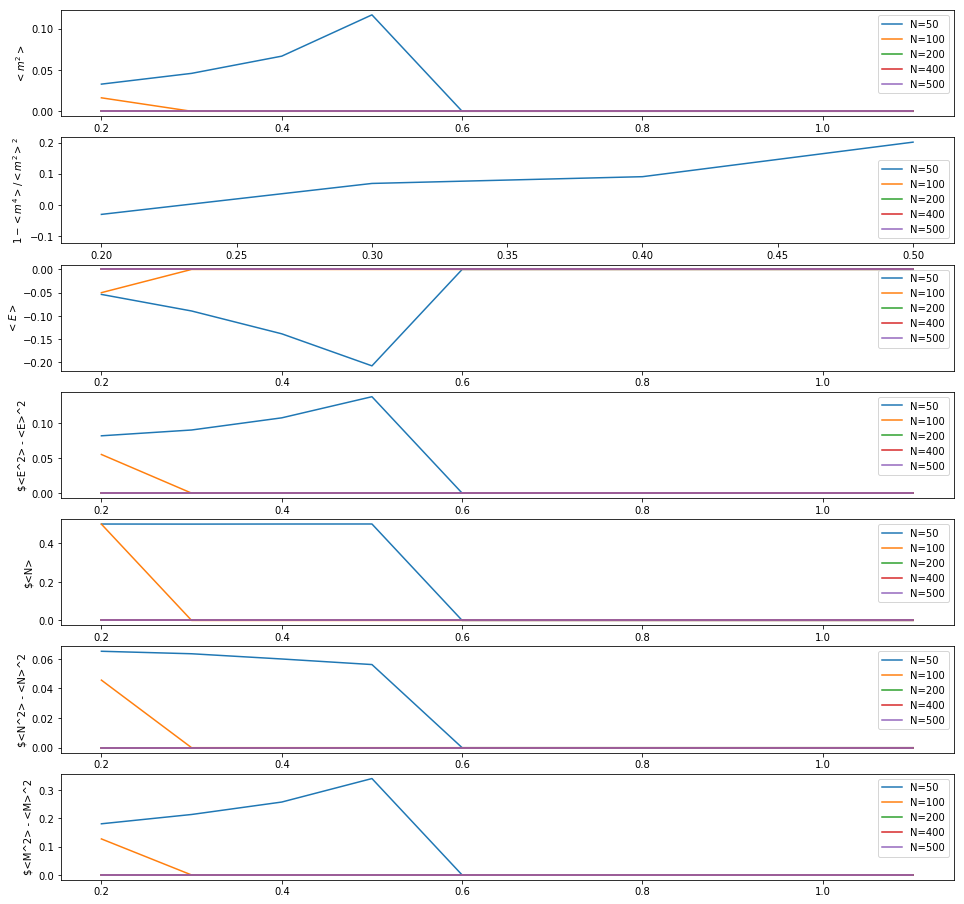

In [18]:
result_filename = working_dir / 'results.hdf5'

with h5py.File(result_filename, 'r+') as data:
    print(list(data.keys()))
    print(data.attrs['loop_over'])
    
    f, axs = plt.subplots(7, figsize = (16,16))
    
    betas = data.attrs['beta']
    N_systems = data.attrs['N_system']

    for i,N_system in enumerate(N_systems):
        #axis 0 = N_system axis 1 = beta

        e = data['energies'][i, :, :] / N_system
        m = data['magnetisations'][i, :, :] /  N_system
        n = data['numbers'][i, :, :] /  N_system
        
        axs[0].plot(betas, (m**2).mean(axis=-1), label = f'N={N_system}')
        axs[0].set(ylabel = r'$<m^2>$')
        axs[1].plot(betas, 1-(m**4).mean(axis=-1)/(m**2).mean(axis=1)**2/3, label = f'N={N_system}')
        axs[1].set(ylabel = r'$1-<m^4>/<m^2>^2$')
        
        axs[2].plot(betas, e.mean(axis=-1), label = f'N={N_system}')
        axs[2].set(ylabel = r'$<E>$')
        axs[3].plot(betas, e.std(axis=-1), label = f'N={N_system}')
        axs[3].set(ylabel = r'$<E^2> - <E>^2')
        
        axs[4].plot(betas, n.mean(axis=-1), label = f'N={N_system}')
        axs[4].set(ylabel = r'$<N>')
        axs[5].plot(betas, n.std(axis=-1), label = f'N={N_system}')
        axs[5].set(ylabel = r'$<N^2> - <N>^2')
        
        axs[6].plot(betas, m.std(axis=-1), label = f'N={N_system}')
        axs[6].set(ylabel = r'$<M^2> - <M>^2')

    for a in axs: a.legend()
    

In [1]:
%load_ext Cython

In [11]:
%%cython --annotate
#cython: boundscheck=False, wraparound=False, infer_types=True

#pull in the random number generation code from the standard lib
cdef extern from "stdlib.h":
    double drand48() nogil
    void srand48(long int seedval) nogil

def py_drand48():
    return drand48()

def py_srand48(seed):
    srand48(seed)

cimport cython
from libc.math cimport exp
import numpy as np
import scipy as sp
from scipy import linalg

#TODO change the code to just rotate a single row of this matrix when needed rather than generating it all the time
def interaction_matrix(N, alpha, V, normalise = True, dtype = np.float64):
    row0 = np.abs((N/np.pi * np.sin(np.pi * np.arange(1,N, dtype = dtype)/N)) ** (-alpha) )
    row0 = np.concatenate([[0,], row0])# put the first 0 in by hand
    if normalise: row0 = row0 / np.sum(row0)
    row0 = V * row0
    return linalg.circulant(row0)

cpdef initialise_state_representations(long [::1] state, double [:, ::1] interaction_matrix):
    'initialise useful representations of the state'
    cdef int N = state.shape[0]

    alternating_signs = np.ones(N, dtype = np.int64)
    ut = np.ones(N, dtype = np.int64)
    t = np.ones(N, dtype = np.int64)


    cdef long [::1] alt_v = alternating_signs
    cdef long [::1] ut_v = ut
    cdef long[::1]  t_v = t
    cdef long[::1] st_v = state


    cdef int s = 1
    cdef int i, j
    for i in range(N):
        s = -s
        alt_v[i] = s
        ut_v[i] = (2*st_v[i] - 1)
        t_v[i] = s * ut_v[i]

    cdef double [:] background = (interaction_matrix @ t)
    return alternating_signs, ut, t, background

cpdef double c_classical_energy(
                                    double mu,
                                    long[::1] state,
                                    long[::1] t,
                                    double [::1] background) nogil:
    'compute the energy of the f electrons'
    cdef int N = state.shape[0]
    cdef double F = 0
    cdef int i
    for i in range(N):
        F += - mu * state[i] + t[i] * background[i]

    return F

cdef void invert_site_inplace(
                        long i,
                        long [::1] alternating_signs,
                        long [::1] state,
                        long [::1] ut,
                        long [::1] t,
                        double [::1] background,
                        double [:, ::1] interaction_matrix,
                       ) nogil:
    'invert site i and update the useful state representations in place'
    cdef long N = state.shape[0]

    state[i] = 1 - state[i]
    ut[i] = -ut[i]
    t[i] = -t[i]

    #these expresions only work if we're already flipped the spin
    cdef long dni = ut[i]
    cdef long dti = 2 * t[i]

    cdef int j
    for j in range(N):
        background[j] += interaction_matrix[i, j] * dti

cpdef double incremental_energy_difference(long i,
                                    double mu,
                                    long[::1] ut,
                                    long[::1] t,
                                    double [::1] background) nogil:
    'compute the energy difference for the site i WHICH HAS BEEN FLIPPED ALREADY'
    cdef long dni = ut[i] #the changes are simply related to the value after flipping too
    cdef long dti = 2*t[i]
    cdef double dF_f =  - mu * dni + 2 * dti * background[i]
    return dF_f

cpdef void cython_mcmc_helper(
                    #outputs
                    double [::1] energies,
                    long [::1] numbers,
                    long [::1] magnetisations,

                    #inputs
                    long [::1] state,
                    long [::1] alternating_signs,
                    long [::1] ut,
                    long [::1] t,
                    double [::1] background,
                    double [:, ::1] interaction_matrix,

                    #parameters
                    long N_steps = 10**5,
                    long N_system = 100,
                    double mu = 0,
                    double beta = 0.1,
                    double V=1,
                    double alpha=1.5,
                   ) nogil:

        cdef double energy = 0
        cdef long number = 0
        cdef long magnetisation = 0

        cdef long dn #the change in the particle number, 0 or 1
        cdef long dt
        cdef double dF #change in free energy

        cdef long new_number #the updated number of particles
        cdef long new_magnetisation
        cdef double new_energy

        cdef long site #the site we're considering flipping

        cdef int i
        for i in range(N_steps):
            #if True: #recalculate the representations every so often
            if (i*N_system)%10**4 == 0: #recalculate the representations every so often
                with gil:
                    new_state = initialise_state_representations(state, interaction_matrix)
                    new_energy = c_classical_energy(mu, state, t, background)
                    new_number = np.sum(state)
                    new_magnetisation = np.sum(t)

                    if i != 0 and (not np.allclose(new_state, [alternating_signs, ut, t, background]) \
                       or not np.allclose(energy, new_energy) \
                       or not (magnetisation == new_magnetisation) \
                       or not (number == new_number)):
                        print(f'''
                            warning3, the incremental update seems to be diverging
                            state: {np.allclose(new_state, [alternating_signs, ut, t, background])}
                            energy: {np.allclose(energy, new_energy)}
                            mag: {magnetisation, new_magnetisation}
                            {list(state)}
                            {list(t)}
                            number: {number, new_number}
                            ''')


                    alternating_signs, ut, t, background = new_state
                    energy = new_energy
                    number = new_number
                    magnetisation = new_magnetisation

            for site in range(N_system):

                invert_site_inplace(site, alternating_signs, state, ut, t, background, interaction_matrix)

                dn = ut[site]
                dt = 2 * t[site]
                dF = incremental_energy_difference(site, mu, ut, t, background)

                #if we must reject this move
                if dF > 0 and exp(- beta * dF) < drand48():
                    #change the site back and don't change the energy
                    invert_site_inplace(site, alternating_signs, state, ut, t, background, interaction_matrix)
                else:
                    #keep the site as it is and update the energy
                    energy += dF
                    number += dn
                    magnetisation += dt

            energies[i] = energy
            numbers[i] = number
            magnetisations[i] = magnetisation

def cython_mcmc(N_steps = 10**4,
                N_system = 1000,
                mu = 0,
                beta = 0.1,
                V=1,
                alpha=1.5,
                return_names = False,
                sample_output = False,
                **kwargs,
               ):

    #python setup code goes here
    state = np.arange(N_system, dtype = np.int64) % 2
    M = interaction_matrix(N=N_system, alpha=alpha, V=V)

    energies = np.zeros(shape = N_steps, dtype = np.float64)
    numbers = np.zeros(shape = N_steps, dtype = np.int64)
    magnetisations = np.zeros(shape = N_steps, dtype = np.int64)

    alternating_signs, ut, t, background = initialise_state_representations(state, interaction_matrix=M)

    #if sample_output is true, we just want to get the shape of the data
    if not sample_output:
        cython_mcmc_helper(
                    #outputs
                    energies,
                    numbers,
                    magnetisations,

                    #inputs
                    state,
                    alternating_signs,
                    ut,
                    t,
                    background,
                    M,

                    #parameters
                    N_steps,
                    N_system,
                    mu,
                    beta,
                    V,
                    alpha,
                   )

    return ('energies', 'numbers', 'magnetisations'), (energies, numbers, magnetisations)

In [35]:
from quantum_montecarlo import quantum_cython_mcmc
import h5py

config = dict(N_steps = 10**4,
              N_system = 128,
              mu = 0,
              beta = 0.1,
              V=-1,
              alpha=1.5,
              U = 1,
              return_names = True,
              #this is necessary for hd5 to know how to save it
            )

quantum_cython_mcmc(**config)

TypeError: unsupported operand type(s) for *: 'float' and 'quantum_montecarlo._memoryviewslice'

Exception ignored in: 'quantum_montecarlo.quantum_cython_mcmc_helper'
Traceback (most recent call last):
  File "quantum_montecarlo.pyx", line 139, in quantum_montecarlo.diagonalise
    double [:, ::1] interaction_matrix,
TypeError: unsupported operand type(s) for *: 'float' and 'quantum_montecarlo._memoryviewslice'


(('classical_energies', 'quantum_energies', 'numbers', 'magnetisations'),
 (array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])))

In [9]:
%%cython --annotate
#cython: boundscheck=False, infer_types=True

cimport numpy as np
import numpy as np
from libc.math cimport floor

def spin_spin_correlation(state):
    '''
    take a state, where the last axis labels spins and compute the correlation function
    for half the system size because it's periodic
    the last axis becomes the correlation function instead
    S(k) = <s_i s_{i+k}> averaged over i
    '''

    #determine the new shape of the data
    output_shape = np.array(state.shape)
    output_shape[-1] = floor(state.shape[-1]/2) + 1
    
    output = np.zeros(shape = output_shape, dtype = state.dtype)
    cdef int shift
    for shift in range(output_shape[-1]):
        output[..., shift] = np.sum(np.roll(state, shift, axis=-1) * state, axis=-1) / state.shape[-1]
    
    output = output - (state[..., np.newaxis].mean(axis=-2)**2)
    
    return output